In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch.nn.functional as F

# Load the bounding box data
df = pd.read_csv('norm_bounding_boxes.csv')

# Define a custom dataset class
class FaceDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        bbox = self.dataframe.iloc[idx, 1:5].values
        image = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
        
        if self.transform:
            image = self.transform(image)
        
        return image, image  # Input image and target are the same for autoencoders

# Transformations
transform = transforms.Compose([
    transforms.Resize((92, 84)),
    transforms.ToTensor()
])

# Initialize dataset and dataloader
dataset = FaceDataset(df, '../celeba/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [376]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # ker = 4
        # std = 4
        
        # Encoder
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 8, 4, 2, 1),
        #     nn.ReLU(True),
        #     nn.Conv2d(8, 16, 4, 2, 1),
        #     nn.ReLU(True),
        #     # nn.Conv2d(16, 32, 4, 2, 1),
        #     # nn.ReLU(True)
        # )
        
        # # Decoder
        # self.decoder = nn.Sequential(
        #     # nn.ConvTranspose2d(64, 32, 7),
        #     # nn.ReLU(True),
        #     # nn.ConvTranspose2d(32, 16, 4, 2, 1, 1),
        #     # nn.ReLU(True),
        #     nn.ConvTranspose2d(16, 8, 4, 2, 1),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(8, 3, 4, 2, 1),
        #     nn.Sigmoid()
        # )

        H = 92
        W = 84

        # Encoder
        self.encoder = nn.Sequential(
            # nn.Conv2d(3, 8, 3, 1, 1),  # Output: (8, H/2, W/2)
            # nn.ReLU(True),
            nn.Conv2d(3, 8, 3, 1, 1),  # Output: (8, H/2, W/2)
            nn.ReLU(True),
            nn.Conv2d(8, 16, 4, 2, 1),  # Output: (8, H/2, W/2)
            nn.ReLU(True),
            nn.Conv2d(16, 32, 4, 2, 1), # Output: (16, H/4, W/4)
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, 1, 1),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(8, 3, 3, 1, 1),
            nn.Sigmoid()
        )

        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# Initialize model, loss function, and optimizer
model = Autoencoder()

# criterion = nn.L1Loss()
# criterion = CosineSimilarityLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)


In [377]:

def cosine_loss(img1, img2):
    # Convert images to tensors if they are in numpy array format
    if isinstance(img1, np.ndarray):
        img1 = torch.tensor(img1, dtype=torch.float32)
    if isinstance(img2, np.ndarray):
        img2 = torch.tensor(img2, dtype=torch.float32)

    # Ensure both images have the same shape and are 3-channel images
    if img1.shape != img2.shape or img1.ndim != 4 or img1.shape[1] != 3:
        raise ValueError("Both images must have the same shape and must be 3-channel images")

    # epsilon = 1e-6
    epsilon = 0
    # Normalize each pixel vector to unit length
    img1_norm = img1 / torch.sqrt(torch.sum(img1 ** 2, dim=1, keepdim=True)) + epsilon
    img2_norm = img2 / torch.sqrt(torch.sum(img2 ** 2, dim=1, keepdim=True)) + epsilon

    # Calculate cosine similarity for each pixel
    cosine_similarity = (img1_norm * img2_norm).sum(dim=1)  # Sum over the channel dimension

    # print(cosine_similarity)

    # cosine_similarity = torch.abs(cosine_similarity)


    cosine_similarity = (1 - cosine_similarity)
    # cosine_similarity = (1 - cosine_similarity) ** 0.5
    
    # cosine_similarity = cosine_similarity * (img1.sum(dim = 1) / 3) ** 0.5
    # cosine_similarity = cosine_similarity * torch.sigmoid(img1.sum(dim = 1) * 100 - 50)
    # val = img1.max(dim = 1)
    val, _ = torch.max(img1, dim=1)
    cosine_similarity = cosine_similarity * torch.sigmoid(val * 10 - 5)

    return cosine_similarity.sum()

criterion = cosine_loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [378]:
from tqdm import tqdm

# Training loop
for i, data in enumerate(tqdm(dataloader, desc="Training Progress")):
    img, target = data
    # Forward pass
    output = model(img)
    loss = criterion(output, target)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Report loss every 25 iterations
    if i % 20 == 0:
        print(f'Iteration {i+1}, Loss: {loss.item():.4f}')


Training Progress:   1%|▏         | 4/307 [00:00<00:17, 17.23it/s]

Iteration 1, Loss: nan


Training Progress:   7%|▋         | 22/307 [00:01<00:29,  9.73it/s]

Iteration 21, Loss: nan


Training Progress:  14%|█▎        | 42/307 [00:04<00:36,  7.17it/s]

Iteration 41, Loss: nan


Training Progress:  20%|██        | 62/307 [00:06<00:31,  7.70it/s]

Iteration 61, Loss: nan


Training Progress:  27%|██▋       | 82/307 [00:09<00:30,  7.46it/s]

Iteration 81, Loss: nan


Training Progress:  33%|███▎      | 102/307 [00:13<00:33,  6.10it/s]

Iteration 101, Loss: nan


Training Progress:  40%|███▉      | 122/307 [00:16<00:24,  7.48it/s]

Iteration 121, Loss: nan


Training Progress:  46%|████▋     | 142/307 [00:18<00:19,  8.55it/s]

Iteration 141, Loss: nan


Training Progress:  51%|█████     | 156/307 [00:20<00:20,  7.52it/s]


KeyboardInterrupt: 

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tensor(tensor):
    """
    Plots images from a 4D tensor (batch, C, W, H) with 3 color channels.
    
    Args:
    tensor (numpy.ndarray): The 4D tensor to plot, with shape (batch, C, W, H).
    """
    if tensor.shape[1] != 3:
        raise ValueError("Tensor must have 3 channels")

    batch_size = tensor.shape[0]
    rows = (batch_size + 5) // 6  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, 6, figsize=(12, 2 * rows))
    fig.tight_layout(pad=1.0)

    # Flattening the axes array for easy iteration
    axes = axes.ravel()

    for i in range(batch_size):
        # Transpose tensor to shape (W, H, C) for plotting
        img = tensor[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
    
    # Turn off axes for any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

torch.Size([12, 3, 92, 84])
torch.Size([12, 3, 92, 84])


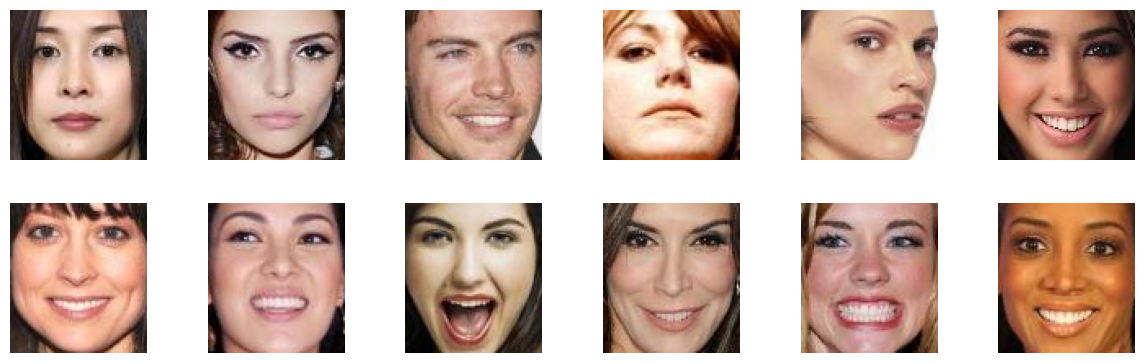

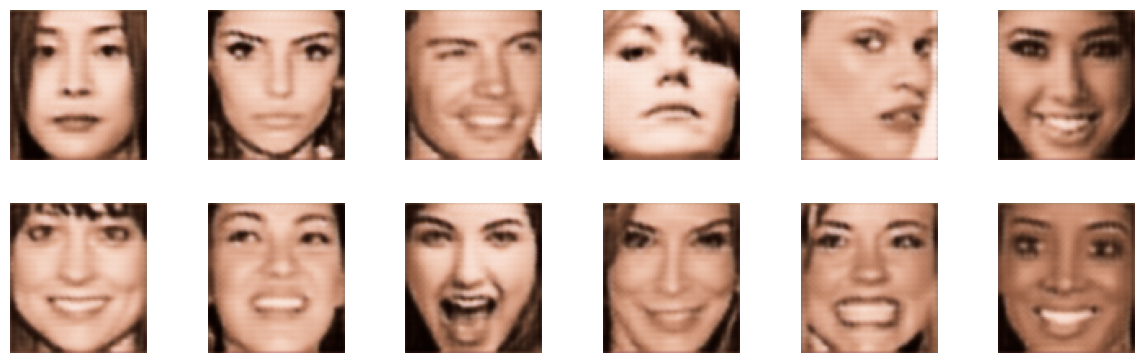

In [358]:

source = torch.stack([dataset[i + 1233][0] for i in range(12)])
rec = model(source).detach()
print(source.shape)
print(rec.shape)

plot_tensor(source)
plot_tensor(rec)

In [320]:
k = dataset[1243][0].unsqueeze(0)
# k = dataset[1234][0].unsqueeze(0)
r = model(k).detach()

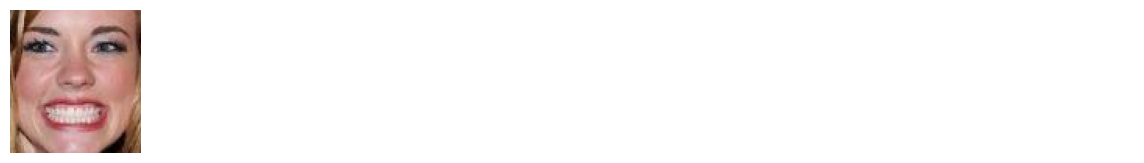

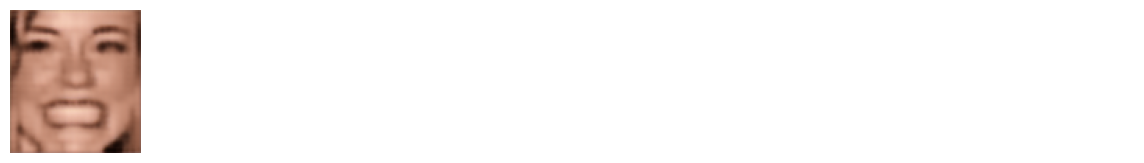

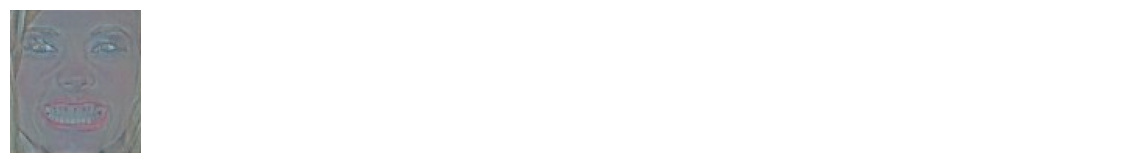

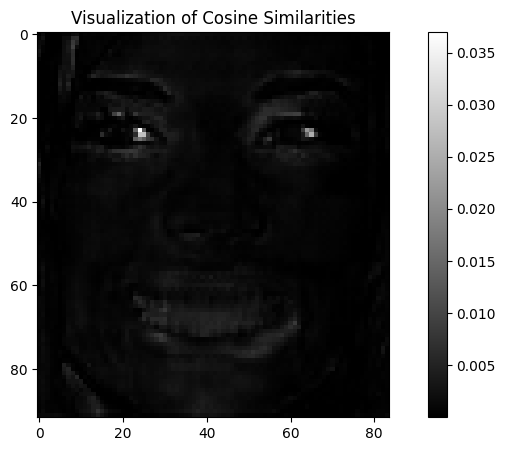

In [321]:
plot_tensor(k)
plot_tensor(r)
plot_tensor(((k - r)/2 + 0.5) )
visualize_cosine(k, r)
# visualize_dot_product_distances(k, k)

In [329]:

def visualize_cosine(img1, img2):
    # Convert images to tensors if they are in numpy array format
    if isinstance(img1, np.ndarray):
        img1 = torch.tensor(img1, dtype=torch.float32)
    if isinstance(img2, np.ndarray):
        img2 = torch.tensor(img2, dtype=torch.float32)

    # Ensure both images have the same shape and are 3-channel images
    if img1.shape != img2.shape or img1.ndim != 4 or img1.shape[1] != 3:
        raise ValueError("Both images must have the same shape and must be 3-channel images")

    # epsilon = 1e-6
    epsilon = 0
    # Normalize each pixel vector to unit length
    img1_norm = img1 / torch.sqrt(torch.sum(img1 ** 2, dim=1, keepdim=True)) + epsilon
    img2_norm = img2 / torch.sqrt(torch.sum(img2 ** 2, dim=1, keepdim=True)) + epsilon

    # Calculate cosine similarity for each pixel
    cosine_similarity = (img1_norm * img2_norm).sum(dim=1)  # Sum over the channel dimension

    # print(cosine_similarity)

    # cosine_similarity = torch.abs(cosine_similarity)


    cosine_similarity = (1 - cosine_similarity)
    # cosine_similarity = (1 - cosine_similarity) ** 0.5
    
    # cosine_similarity = cosine_similarity * (img1.sum(dim = 1) / 3) ** 0.5
    # cosine_similarity = cosine_similarity * torch.sigmoid(img1.sum(dim = 1) * 100 - 50)
    # val = img1.max(dim = 1)
    val, _ = torch.max(img1, dim=1)
    cosine_similarity = cosine_similarity * torch.sigmoid(val * 10 - 5)
    # cosine_similarity = cosine_similarity * (-1/(2 * val + 1) + 1)


    # Normalize the cosine similarity image to [0, 1] for visualization
    # normalized_cosine_similarity = (cosine_similarity + 1) / 2  # Scale from [-1, 1] to [0, 1]
    normalized_cosine_similarity = cosine_similarity


    # Visualize the result using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(normalized_cosine_similarity[0], cmap='gray')  # Visualizing the first image in batch
    plt.colorbar()
    plt.title('Visualization of Cosine Similarities')
    plt.show()

In [ ]:
def cosine_criterion

In [139]:
def visualize_dot_product_distances(img1, img2):
    # Convert images to tensors if they are in numpy array format
    if isinstance(img1, np.ndarray):
        img1 = torch.tensor(img1, dtype=torch.float32)
    if isinstance(img2, np.ndarray):
        img2 = torch.tensor(img2, dtype=torch.float32)

    # Ensure both images have the same shape and are 3-channel images
    if img1.shape != img2.shape or img1.ndim != 4 or img1.shape[1] != 3:
        raise ValueError("Both images must have the same shape and must be 3-channel images")

    # Calculate dot product for each pixel
    dot_product = (img1 * img2).sum(dim=1)  # Sum over the channel dimension

    # Normalize the dot product image to [0, 1] for visualization
    min_val = dot_product.min()
    max_val = dot_product.max()
    normalized_dot_product = (dot_product - min_val) / (max_val - min_val)

    # Visualize the result using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(normalized_dot_product[0], cmap='gray')  # Visualizing the first image in batch
    plt.colorbar()
    plt.title('Visualization of Dot Product Distances')
    plt.show()

In [ ]:
torch.nn.functional